In [1]:
from nilearn import plotting
import os
import matplotlib.pyplot as plt
import nibabel as nib
import seaborn as sns
import numpy as np
import sys

sys.path.append(os.path.join(os.environ.get("HOME"),"CNP_analysis"))
from utils import get_config

%matplotlib inline

/home/jdurnez/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
sns.set_style("whitegrid")

## Comparison of results from 1 (random) subject

In [3]:
basedir = os.environ.get("PREPBASEDIR")
pipelines = ['fslfeat_5.0.9','fmriprep-1.0.3']
subject = 'sub-50073'

images = {}
for pipeline in pipelines:
    z11 = os.path.join(basedir,'fmriprep_vs_feat/%s/task/%s/stopsignal.feat/stats/tstat11.nii.gz'%(pipeline,subject))
    images[pipeline] = z11

/share/PI/russpold/software/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


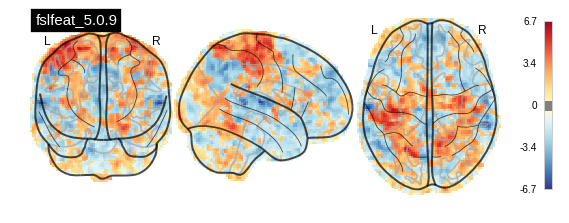

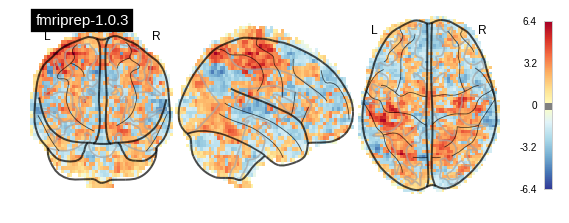

In [4]:
for idx,pipeline in enumerate(pipelines):
    plotting.plot_glass_brain(images[pipeline],title=pipeline,cmap='RdYlBu_r',
                              colorbar=True,symmetric_cbar=True,plot_abs=False)
plotting.show()

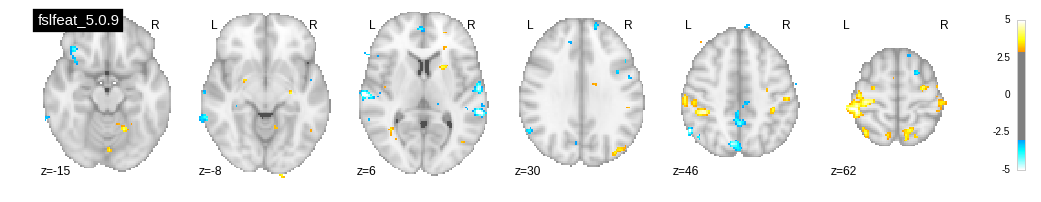

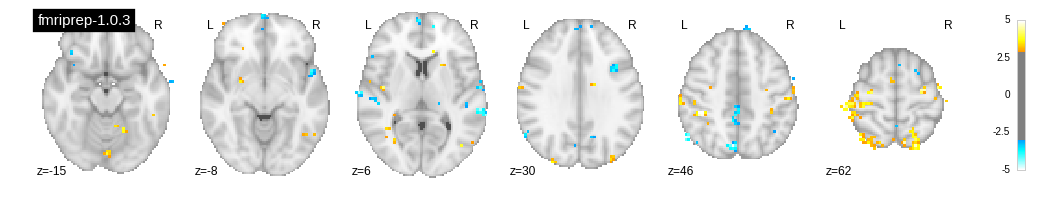

In [5]:
cut_coords = [-15, -8, 6, 30, 46, 62]
for idx,pipeline in enumerate(pipelines):
   plotting.plot_stat_map(images[pipeline],title=pipeline,vmax=5,display_mode='z',threshold=2.98,cut_coords=cut_coords)
plotting.show()

# Compare masks

In [6]:
meanmasks = {}
totalmasks = {}
subjects = {}
pipelines = ['fslfeat_5.0.9','fmriprep-1.0.3']

for pipeline in pipelines:
    taskdir = os.path.join(basedir,'fmriprep_vs_feat',pipeline,'task')
    subjects[pipeline] = os.listdir(taskdir)
    dims = [65,77,49] if pipeline.startswith('fmriprep') else [97,115,97]
    mask = np.zeros(dims+[len(subjects[pipeline])])
    for idx,subject in enumerate(subjects[pipeline]):
        cf = get_config.get_files(pipeline,subject,'stopsignal')
        maskfile = cf['standard_mask']
        #maskfile = os.path.join(taskdir,subject,'stopsignal.feat/mask.nii.gz')
        if idx==0:
            aff = nib.load(maskfile).affine
            hd = nib.load(maskfile).header
        mask[:,:,:,idx] = nib.load(maskfile).get_data()  
    mnmask = np.mean(mask,3)
    totmask = (mnmask>0)*1.
    meanmasks[pipeline] = nib.Nifti1Image(mnmask, affine = aff, header = hd)
    totalmasks[pipeline] = nib.Nifti1Image(totmask, affine = aff, header = hd)

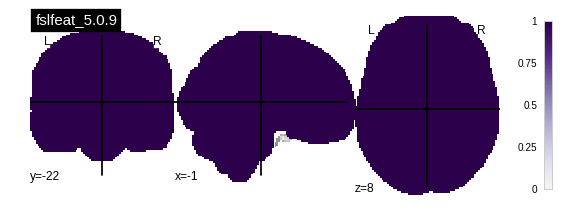

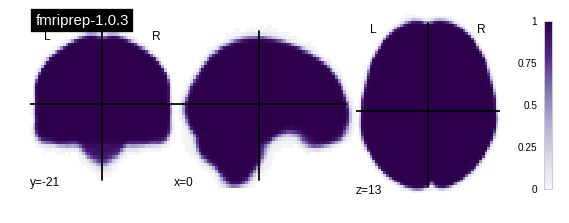

In [7]:
for idx,pipeline in enumerate(pipelines):
    plotting.plot_stat_map(meanmasks[pipeline],title=pipeline,cmap='PuOr',
                              colorbar=True)

plotting.show()

# Comparison of distribution of T-values in single subjects analyses.

In [8]:
# collect all subjects
prepdir = os.environ.get("PREPBASEDIR")
fmriprepdir = os.path.join(prepdir,'fmriprep-1.0.3','fmriprep')
subjects = [x for x in os.listdir(fmriprepdir) if x[-4:]!='html' and x[:4]=='sub-']

subs = []
for subject in subjects:
    image = os.path.join(prepdir,'fmriprep-1.0.3','fmriprep',subject,'func',
                         '%s_task-%s_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'%(subject,'stopsignal'))
    if os.path.exists(image):
        subs.append(subject)

subs = set(subs)-set(['sub-50010','sub-11067','sub-10527'])
subjects = list(subs)


In [9]:
tvals = {}
for pipeline in pipelines:
    tvals[pipeline]=[]
    for subject in subjects:
        t11 = os.path.join(prepdir,'fmriprep_vs_feat/%s/task/%s/stopsignal.feat/stats/tstat11.nii.gz'%(pipeline,subject))
        im = nib.load(t11).get_data()
        imnonnul = im[im!=0]
        tvals[pipeline] += imnonnul.tolist()

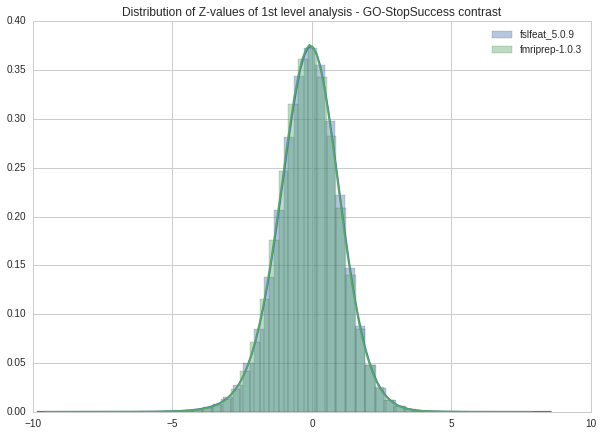

In [10]:
plt.figure(figsize=(10,7))
for pipeline in pipelines:
    sns.distplot(tvals[pipeline],label=pipeline)
plt.title("Distribution of Z-values of 1st level analysis - GO-StopSuccess contrast")
plt.legend()

# Activation count maps

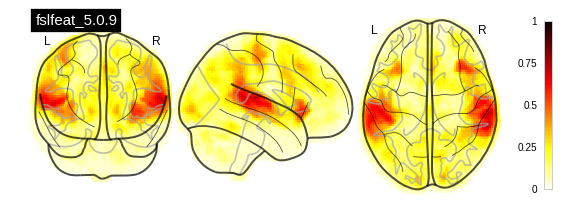

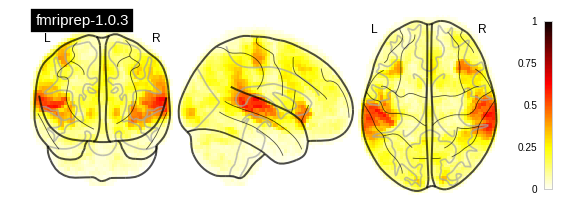

In [11]:
#cut_coords = [-15, -8, 6, 30, 46, 62]
for idx,pipeline in enumerate(pipelines):
    image = os.path.join(basedir,'fmriprep_vs_feat',pipeline,"task_acm/stopsignal/zstat11_ACM_diff.nii.gz")
    plotting.plot_glass_brain(image,title=pipeline,vmin=-1,vmax=1,colorbar=True)
plotting.show()

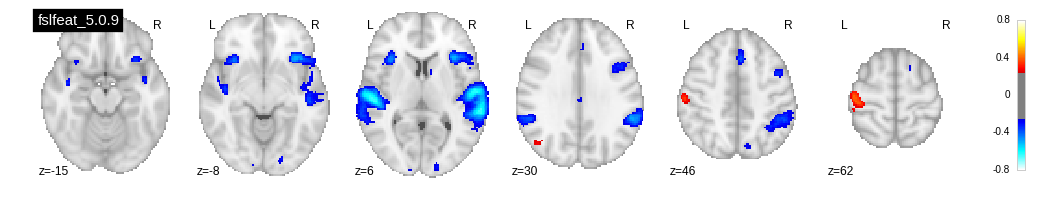

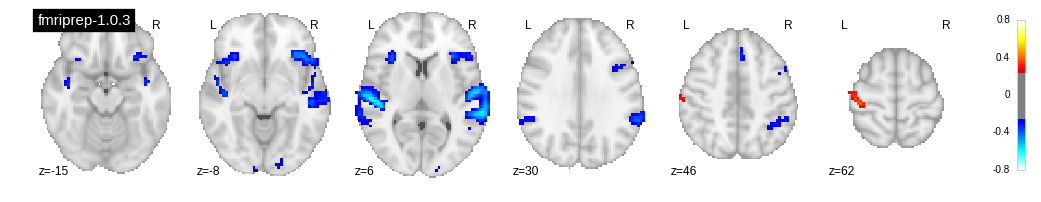

In [12]:
cut_coords = [-15, -8, 6, 30, 46, 62]
for idx,pipeline in enumerate(pipelines):
    image = os.path.join(basedir,'fmriprep_vs_feat',pipeline,"task_acm/stopsignal/zstat11_ACM_diff.nii.gz")
    plotting.plot_stat_map(image,title=pipeline,threshold=0.25,display_mode='z',cut_coords=cut_coords,vmax=0.8)
plotting.show()

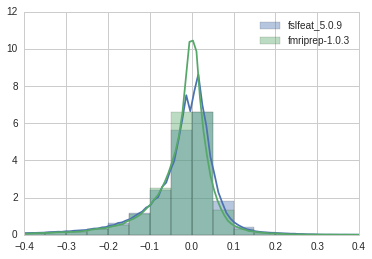

In [13]:
for idx,pipeline in enumerate(pipelines):
    image = os.path.join(basedir,'fmriprep_vs_feat',pipeline,"task_acm/stopsignal/zstat11_ACM_diff.nii.gz")
    imdat = nib.load(image).get_data()
    sns.distplot(imdat[imdat != 0],label=pipeline,norm_hist=True,bins=np.arange(-1,1,0.05))
plt.xlim([-0.4,0.4])
plt.legend()